In [1]:
import sys
import torch


seed = 42
#torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy
import matplotlib.pyplot as plt 
import seaborn as sns

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree
import fiora.visualization.spectrum_visualizer as sv
import json
from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework
from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder
import fiora.visualization.spectrum_visualizer as sv

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


[12:00:14] WARNING: not removing hydrogen atom without neighbors
[12:00:14] WARNING: not removing hydrogen atom without neighbors
[12:00:14] WARNING: not removing hydrogen atom without neighbors


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


### Load Feature encoder classes and current model

In [2]:


node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

depth = 6
MODEL_PATH = f"{home}/data/metabolites/pretrained_models/pre_package/v0.0.1_merged_depth{depth}_Jan24+CCS+RT.pt"

try: 
    model = GNNCompiler.load(MODEL_PATH)
except:
    try:
        print(f"Warning: Failed loading the model {MODEL_PATH}. Fall back: Loading the model from state dictionary.")
        model = GNNCompiler.load_from_state_dict(MODEL_PATH)
        print("Model loaded from state dict without further errors.")
    except:
        raise NameError("Error: Failed loading from state dict.")
        

dev = "cuda:1"

model.eval()
model = model.to(dev)
fiora = SimulationFramework(None, dev=dev, with_RT=True, with_CCS=True)

## Example predictions

### Verapamil

In [3]:
from fiora.MOL.Metabolite import Metabolite

smiles = "CC(C)C(CCCN(C)CCC1=CC(=C(C=C1)OC)OC)(C#N)C2=CC(=C(C=C2)OC)OC"
summary = {"name": "Verapamil","precursor_mode": "[M+H]+", "collision_energy": 25, "instrument": "HCD"}

metabolite = Metabolite(smiles)

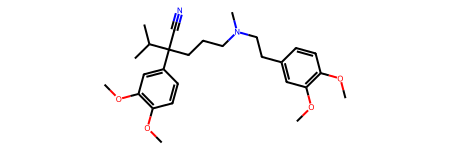

In [7]:
metabolite.MOL

In [5]:
# Create structure graphs and fragmentation trees
metabolite.create_molecular_structure_graph()
metabolite.compute_graph_attributes(node_encoder, bond_encoder)
# Map covariate features to dedicated format and encode
metabolite.add_metadata(summary, setup_encoder, rt_encoder)
# Fragment coumpound
metabolite.fragment_MOL(depth=1)

# Predict spectrum
pred = fiora.simulate_and_score(metabolite, model=model)

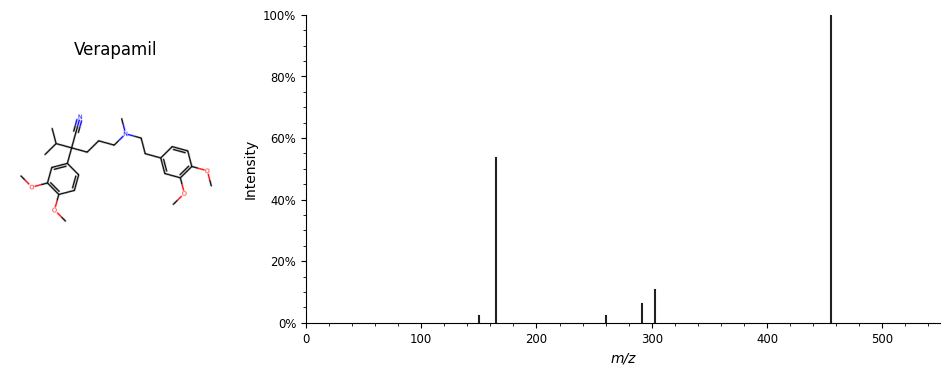

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
img = metabolite.draw(ax= axs[0])
axs[0].set_title(summary["name"])
sv.plot_spectrum({"peaks": pred["sim_peaks"]}, ax=axs[1])
plt.show()